# Setup
This notebook is basically a mix of make_dataset.py from ../snn with encoding using delta modulation and adding waveform data 

In [1]:
import argparse
import speech2spikes
import torchaudio
import torch
import random
import numpy as np
import os
import pywt
import noisereduce

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

from common import write_spikes_to_disk

%matplotlib inline

/home/joao/dev/neuromorphic/neurovenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define variables for encoding
MODE = 'spec' # spec, dwt
DATASET_CAP = 20
FILEPATH = './data/test.npz' # for saving
DM_THRESHOLD = 0.001

SPEC_FREQ_BIN_COUNT = 25 # for spec mode

PATH_GUNSHOT_SOUNDS = '/home/joao/dev/MLAudio/shotspotter/data/gunshotsNew'
PATH_GUNSHOT_INDEX = '/home/joao/dev/MLAudio/shotspotter/data/gunshotsNewIndex.csv'
PATH_NOGUNSHOT_SOUNDS = '/home/joao/dev/MLAudio/shotspotter/data/genBackgrounds'

In [3]:
gunshot_file_paths = [PATH_GUNSHOT_SOUNDS+'/'+fn for fn in os.listdir(PATH_GUNSHOT_SOUNDS)][:DATASET_CAP//2]
print(f'We have {len(gunshot_file_paths)} gunshot audio files')
nogunshot_file_paths = [PATH_NOGUNSHOT_SOUNDS+'/'+fn for fn in os.listdir(PATH_NOGUNSHOT_SOUNDS)][:DATASET_CAP//2]
print(f'We have {len(nogunshot_file_paths)} background only audio files')

p1 = [(i, 1) for i in gunshot_file_paths]
p2 = [(i, 0) for i in nogunshot_file_paths]

pairs = p1+p2 # path to sound - label tuples
random.shuffle(pairs)

We have 10 gunshot audio files
We have 10 background only audio files


# Encoding

In [4]:
# input is shape time x batch x channels (from spectrogram or dwt spec)
def posneg_delta(raw_spec_data):
    delta = spikegen.delta(raw_spec_data, threshold=DM_THRESHOLD, off_spike=True)
    
    new_data = torch.zeros(delta.shape[0], delta.shape[1], delta.shape[2]*2) # 2 channels for each freq channel
    for i in range(delta.shape[1]): # for each sample
        for timestep in range(delta.shape[0]):
            for channel in range(delta.shape[2]):
                if delta[timestep, i, channel] == 1:
                    new_data[timestep, i, channel] = 1
                elif delta[timestep, i, channel] == -1:
                    new_data[timestep, i, channel+delta.shape[2]] = 1;

    return new_data

def to_spikes(paths_list, labels):
    if MODE == 'spec':
        all_spikes = []
        all_waveforms = []
        targets = np.array(labels)

        for p in paths_list:
            samples, rate = torchaudio.load(p, normalize=True)
            
            if samples.shape[0] == 2: samples = samples[0, :]
            else: samples = samples[0]
            if(len(samples) < 24000):
                samples = torch.cat((samples, torch.tensor([0])))

            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)
            
            samples = torch.tensor(noisereduce.reduce_noise(y=samples, sr=rate)) # testing this because I had it on in the ResNet version dataset

            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)

            # freq bin count is nfft//2 + 1
            spec_transform = torchaudio.transforms.Spectrogram(n_fft=(2*SPEC_FREQ_BIN_COUNT-2))

            samples = samples.to(torch.float64)
            spec = spec_transform(samples)

            # convert waveform to spikes
            timesteps = spec.shape[1]
            waveform_timestep_len = (24000//timesteps) + 1

            ts_waveform = [] # timesteps but compressed to time resolution of spectrogram output
            current_t = waveform_timestep_len
            while current_t <= 24000:
                ts_waveform.append(samples[current_t-waveform_timestep_len: current_t].mean())
                current_t += waveform_timestep_len

            if len(ts_waveform) < timesteps: # pad so dimensions match
                ts_waveform.append(0) 

            # normalize because amplitude scales vary a lot (and we did this in resnet accidentally)
            ts_waveform = torch.tensor(ts_waveform)
            ts_waveform = (ts_waveform - ts_waveform.min()) / (ts_waveform.max() - ts_waveform.min())

            # debug
            #plt.plot(np.linspace(0, len(samples), len(samples)), samples)
            #plt.plot(np.linspace(0, len(ts_waveform), len(ts_waveform)), ts_waveform)

            # convert compressed waveform into spikes using bins
            waveform_spikes = []
            num_bins = 20
            bin_size = 1/num_bins
            for w in ts_waveform:
                waveform_spikes.append([0 for i in range(num_bins)])
                waveform_spikes[-1][int(w//bin_size)] = 1

            waveform_spikes = torch.tensor(waveform_spikes)

            # debug
            # fig = plt.figure(facecolor="w", figsize=(10, 5))
            # ax = fig.add_subplot(111)
            # splt.raster(waveform_spikes, ax, s=5, c="black")

            all_spikes.append(spec)
            all_waveforms.append(waveform_spikes)

        # global max/min normalization
        global_min = 0
        global_max = 0
        for s in all_spikes:
            if s.min() < global_min: global_min = s.min()
            if s.max() > global_max: global_max = s.max()

        # now normalize everything
        for i in range(len(all_spikes)):
            all_spikes[i] = (all_spikes[i]-global_min) / (global_max - global_min)

        all_spikes = torch.stack(all_spikes)
        all_waveforms = torch.stack(all_waveforms)

        # delta modulate spectrogram
        all_spikes = all_spikes.permute(2, 0, 1)
        all_spikes_dm = posneg_delta(all_spikes)

        # note: here, all_spikes_dm is (timestep, batch, neuron) and all_waveforms is (batch, timestep, neuron)
        all_waveforms = all_waveforms.permute(1, 0, 2)

        return torch.cat((all_spikes_dm, all_waveforms), dim=2), torch.tensor(labels)

In [5]:
spikes, labels = to_spikes([i[0] for i in pairs], [i[1] for i in pairs])

In [6]:
# training/validation/test split and save
train_cutoff_index = int(DATASET_CAP*0.8)
test_val_cutoff_offset = int(DATASET_CAP*0.1)
training_spikes = spikes[:, 0:train_cutoff_index, :]
training_labels = labels[0:train_cutoff_index]
training_gunshot_data = []

validation_spikes = spikes[:, train_cutoff_index:train_cutoff_index+test_val_cutoff_offset, :]
validation_labels = labels[train_cutoff_index:train_cutoff_index+test_val_cutoff_offset]
validation_gunshot_data = []
validation_filenames = [i[0] for i in pairs][train_cutoff_index:train_cutoff_index+test_val_cutoff_offset]

test_spikes = spikes[:, train_cutoff_index+test_val_cutoff_offset:, :]
test_labels = labels[train_cutoff_index+test_val_cutoff_offset:]

metadata = [f'dm-threshold: {DM_THRESHOLD}', 'mode: spec', 'format: snntorch']
write_spikes_to_disk(FILEPATH, metadata, training_spikes, training_labels, training_gunshot_data,
validation_spikes, validation_labels, validation_gunshot_data, validation_filenames, test_spikes, test_labels)

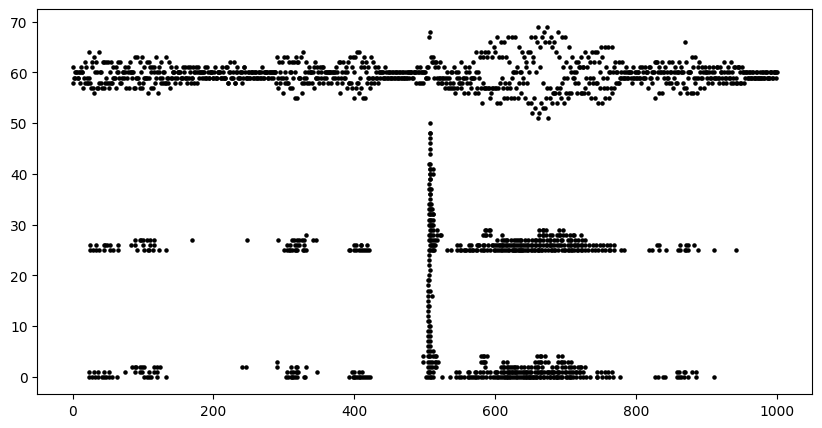

In [249]:
# visualize output
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spikes[:, 3, :], ax, s=5, c="black")